In [76]:
# Surpress warnings
import warnings
warnings.filterwarnings("ignore")

# Import libraries for benchmarking
from pmlb import dataset_names, classification_dataset_names, regression_dataset_names, fetch_data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import pickle
from joblib import dump, load
import sys
import math
import dill

# Import libraries for multithreading
import time
import shutil
from multiprocessing import Process, current_process, Manager, Value, active_children

# Import SK-learn and AutoSK-Learn
import autosklearn.classification
import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

In [77]:
# Read user arguments with argparse
import argparse

parser = argparse.ArgumentParser(description='Run Auto-SkLearn on PMLB datasets')

parser.add_argument('-min', '--minset', type=int, metavar='', required=False, default=1, help = 'Min dataset number (default 1)')
parser.add_argument('-max', '--maxset', type=int, metavar='', required=False, default=166, help = '# Max dataset number (default is 166 for classifcation, 120 for regression)')
parser.add_argument('-mem', '--memory', type=int, metavar='', required=False, default=3072, help = '# Memory capacity for the AutoSklean script (default 3072MB)')
parser.add_argument('-noxg', '--no_xgboost', action='store_true', help = '# Remove XGBoost library from being used in Auto-SkLearn')
parser.add_argument('-t', '--maxtime', type=int, metavar='', required=False, default=1, help = 'Maximum time to run the model for in seconds(default 3600)')
parser.add_argument('-i', '--interval', type=int, metavar='', required=False, default=60, help = 'Interval in seconds to record data for each model')

class_group = parser.add_mutually_exclusive_group()
class_group.add_argument('-r', '--regre_sets', action='store_true', help='Benchmark on regression sets')
class_group.add_argument('-c', '--class_sets', action='store_true', help='Benchmark on classification sets (default)')

_StoreTrueAction(option_strings=['-c', '--class_sets'], dest='class_sets', nargs=0, const=True, default=False, type=None, choices=None, help='Benchmark on classification sets (default)', metavar=None)

In [78]:
args = parser.parse_args(['-min','7','-max','10','-noxg','-t', '120', '-i', '60', '-r'])

In [79]:
# Assign variables based on arguments
minset = args.minset
maxset = args.maxset
max_time = args.maxtime
regre_sets = args.regre_sets
class_sets = args.class_sets
no_xgboost = args.no_xgboost
memory_cap = args.memory
interval = args.interval

In [80]:
# Set classification sets to default if no class was selected
if not regre_sets and not class_sets:
    class_sets = True

# Rescale dataset max number to be within boundaries
if maxset < minset:
    temp = maxset
    maxset = minset
    minset = temp
if minset < 1:
    minset = 1
    print('Minset provided is less than 1, changed to 1.')
if class_sets and maxset > 166:
    maxset = 166
    print('Maxset provided is greater than 166, changed to 166.')
if regre_sets and maxset > 120:                
    maxset = 120
    print('Maxset provided is greater than 120, changed to 120.')  

In [81]:
print(minset)
print(maxset)
print(max_time)
print(regre_sets)
print(class_sets)
print(no_xgboost)
print(memory_cap)
print(interval)

7
10
120
True
False
True
3072
60


In [93]:
# Create a dictionary of the number of features, instances, and classes per classification dataset
# Potentially look into including number of binary, integer, and float features in the future

final_datasets = []
dataset_props = {}

if class_sets:
    dataset_names = classification_dataset_names[minset-1: maxset] 
if regre_sets:
    dataset_names = regression_dataset_names[minset-1: maxset]        

dataset_number = minset;
for dataset in dataset_names:
    print(dataset)
    X, y = fetch_data(dataset, return_X_y=True)
    num_instances, num_features =  X.shape
    print(num_instances)
    if num_instances > 500000:
        dataset_number += 1
        continue        
    num_classes = (np.unique(y)).size if class_sets else -1
    dataset_props[dataset] = (num_instances, num_features, num_classes, dataset_number)
    final_datasets.append(dataset)
    dataset_number += 1

1191_BNG_pbc
1000000
1193_BNG_lowbwt
31104
1196_BNG_pharynx
1000000
1199_BNG_echoMonths
17496


In [96]:
dataset_props

{'1193_BNG_lowbwt': (31104, 9, -1, 8),
 '1199_BNG_echoMonths': (17496, 9, -1, 10)}

In [83]:
# Set the tmp folders where the models will take data out of
tmp_folder = '/tmp/autosklearn_parallel_example_tmp'
output_folder = '/tmp/autosklearn_parallel_example_out'

# Clear the folders if there are contents from previous runs
def clear_tmp_folders():
    for dir in [tmp_folder, output_folder]:
        try:
            shutil.rmtree(dir)
        except OSError as e:
            print('Exception occurred')

In [84]:
# A function to run the main model on the main training data
def run_main_model(dataset, X_train, y_train, max_time, memory_cap, tmp_folder, output_folder, interval, model_done, model_failed):
    curr_dataset_results = {}
    # Run the classifier
    automl = 0;

    if class_sets:
        if no_xgboost:
            automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = max_time,
                                                                      ml_memory_limit = memory_cap,
                                                                      exclude_estimators = 'xgradient_boosting.py',
                                                                      shared_mode=True,
                                                                      tmp_folder=tmp_folder,
                                                                      output_folder=output_folder,
                                                                      delete_tmp_folder_after_terminate=False,
                                                                      delete_output_folder_after_terminate=False,
                                                                      seed=1)
        else:
            automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = max_time, 
                                                                      ml_memory_limit = memory_cap,
                                                                      shared_mode=True,
                                                                      tmp_folder=tmp_folder,
                                                                      output_folder=output_folder,
                                                                      delete_tmp_folder_after_terminate=False,
                                                                      delete_output_folder_after_terminate=False,
                                                                      seed=1)
    if regre_sets:
        if no_xgboost:
            automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task = max_time, 
                                                                 ml_memory_limit = memory_cap,
                                                                 exclude_estimators = 'xgradient_boosting.py',
                                                                 shared_mode=True,
                                                                 tmp_folder=tmp_folder,
                                                                 output_folder=output_folder,
                                                                 delete_tmp_folder_after_terminate=False,
                                                                 delete_output_folder_after_terminate=False,
                                                                 seed=1)
        else:
            automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task = max_time, 
                                                                 ml_memory_limit = memory_cap,
                                                                 shared_mode=True,
                                                                 tmp_folder=tmp_folder,
                                                                 output_folder=output_folder,
                                                                 delete_tmp_folder_after_terminate=False,
                                                                 delete_output_folder_after_terminate=False,
                                                                 seed=1)

    # Use the fit and test with AutoSkLearn on the current data.
    # If exception occurs, continue to next dataset.
    try:
        print("Auto-SKLearn, fitting")
        automl.fit(X_train, y_train)
        model_done.value = True
        print("Auto-SKLearn, testing")        
        current_score = automl.score(X_test, y_test)                            
        print("Auto-SKLearn, finished testing on set ", str(dataset_props[dataset][3]))
        print("Current set Autosklearn final score: ", str(current_score))
    except:        
        print("EXCEPTION: CURRENT DATASET FAILED WITH AUTOSKLEARN. CONTINUING TO NEXT DATASET.")
        model_done.value = True
        model_failed.value = True

In [85]:
# A function that will be threaded periodically to take snapshots of the main model
def snapshot_model_and_score(X_test, y_test, max_time, memory_cap, tmp_folder, output_folder, 
                             seed, curr_snap_time, dataset_props, df_rows_list, class_sets, regre_sets, interval):
    if class_sets:
        snapshot = autosklearn.classification.AutoSklearnClassifier(
                time_left_for_this_task=15,
                per_run_time_limit = 1,
                shared_mode=True, # tmp folder will be shared between seeds
                tmp_folder=tmp_folder,
                output_folder=output_folder,
                delete_tmp_folder_after_terminate=False,
                delete_output_folder_after_terminate=False,
                seed=seed,)
    if regre_sets:
        snapshot = autosklearn.regression.AutoSklearnRegressor(
                time_left_for_this_task=15,
                per_run_time_limit = 1,
                shared_mode=True, # tmp folder will be shared between seeds
                tmp_folder=tmp_folder,
                output_folder=output_folder,
                delete_tmp_folder_after_terminate=False,
                delete_output_folder_after_terminate=False,
                seed=seed,)            

    # Run the snapshot model to retrieve the model information from the temp folder
    # This solution is not ideal even though it works. It may print an error.
    
    try:
        snapshot.fit(X_test, y_test)
    except:
        print("EXCETION ON SNAPSHOT FITTING ", str(dataset_props[dataset][3]))
    
    y_hat = snapshot.predict(X_test)
    if class_sets:
        curr_model_score = autosklearn.metrics.accuracy(y_test, y_hat)
        print(f"Current snapshot accuracy score at time {curr_snap_time}: {curr_model_score}")
        
    if regre_sets:
        curr_model_score = autosklearn.metrics.mean_squared_error(y_test, y_hat)
        print(f"Current snapshot MSE score at time {curr_snap_time}: {curr_model_score}")    
    
        
    # Store the result in a dictionary
    curr_dataset_results = {}
    curr_dataset_results['name'] = dataset
    curr_dataset_results['number'] = dataset_props[dataset][3]
    curr_dataset_results['num_instances'] = dataset_props[dataset][0]
    curr_dataset_results['num_features'] = dataset_props[dataset][1]
    curr_dataset_results['num_classes'] = dataset_props[dataset][2]
    curr_dataset_results['time_stamp'] = curr_snap_time
    curr_dataset_results['models']  = snapshot.get_models_with_weights()
    
    if class_sets:
        curr_dataset_results['accuracy'] = autosklearn.metrics.accuracy(y_test, y_hat)
        curr_dataset_results['balanced_accuracy'] = autosklearn.metrics.balanced_accuracy(y_test, y_hat)
        curr_dataset_results['f1_macro'] = autosklearn.metrics.f1_macro(y_test, y_hat)
        curr_dataset_results['f1_micro'] = autosklearn.metrics.f1_micro(y_test, y_hat)
        curr_dataset_results['f1_weighted'] = autosklearn.metrics.f1_weighted(y_test, y_hat)
        curr_dataset_results['precision_macro'] = autosklearn.metrics.precision_macro(y_test, y_hat)
        curr_dataset_results['precision_micro'] = autosklearn.metrics.precision_micro(y_test, y_hat)
        curr_dataset_results['precision_weighted'] = autosklearn.metrics.precision_weighted(y_test, y_hat)
        curr_dataset_results['recall_macro'] = autosklearn.metrics.recall_macro(y_test, y_hat)
        curr_dataset_results['recall_micro'] = autosklearn.metrics.recall_micro(y_test, y_hat)
        curr_dataset_results['recall_weighted'] = autosklearn.metrics.recall_weighted(y_test, y_hat)
        
    if regre_sets:
        curr_dataset_results['r2'] = autosklearn.metrics.r2(y_test, y_hat)
        curr_dataset_results['mean_squared_error'] = autosklearn.metrics.mean_squared_error(y_test, y_hat)
        curr_dataset_results['mean_absolute_error'] = autosklearn.metrics.mean_absolute_error(y_test, y_hat)
        curr_dataset_results['median_absolute_error'] = autosklearn.metrics.median_absolute_error(y_test, y_hat)

    # Append current dictionary to a list of dictionary
    df_rows_list.append(curr_dataset_results)                

    # Create a Pandas Dataframe with the results
    autosklearn_df = pd.DataFrame(list(df_rows_list))
    #autosklearn_df.sort_values(by=['number', 'time_stamp'])

    # Save results into a CSV after every round
    set_type_string = 'c' if class_sets else 'r'

    csv_file_name = 'PMLB_benchmark_results/' + set_type_string + str(dataset_props[dataset][3]) + '_' + \
                'maxtime' + str(max_time) + '_'+ 'interval' + str(interval) + '.csv'
    print('saved to ', csv_file_name)

    autosklearn_df.to_csv(file_name, sep='\t')
    
    # Save the pickled model
    # Cannot do this since we cannot pickle within a subprocess
    model_file_name = 'Saved_models/' + set_type_string + str(dataset_props[dataset][3]) + '_' + 'maxtime' + str(max_time) + '_' + 'interval' + str(interval) + '.sav'    
    dump(snapshot, model_file_name)
    print('Successfully saved snapshot model to ', model_file_name)
    


In [89]:
dataset_props

{'1193_BNG_lowbwt': (31104, 9, -1, 8),
 '1199_BNG_echoMonths': (17496, 9, -1, 10)}

In [88]:
manager = Manager()

# Add performance results of the datasets that we query on to a final dataframe to output
for dataset in dataset_names:    
    shared_list = manager.list()
    # Split the data to training and test sets
    X, y = fetch_data(dataset, return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

    clear_tmp_folders()        
    print("")
    print("Auto-SKLearn, on dataset ", dataset, " | Number: ", str(dataset_props[dataset][3]), "max of ", str(maxset))
    print("Properties: ")    
    print(str(dataset_props[dataset]))
    
    model_done = Value('b', False)
    model_failed = Value('b', False)
    
    # Start the base process for running the automl model
    base_model_process = Process(target = run_main_model, args = (dataset, 
                                                                  X_train.copy(), 
                                                                  y_train.copy(), 
                                                                  max_time, 
                                                                  memory_cap, 
                                                                  tmp_folder, 
                                                                  output_folder,
                                                                  interval,
                                                                  model_done,
                                                                  model_failed))

    print('base model will start')
    base_model_process.start()
    print('base model started')
    
    snap_time = 0
    # Take periodic snapshots of the model
    while not model_done.value:
        print('Snapshotting')
        time.sleep(interval)
        seed = snap_time + 2
        curr_snap_time = (snap_time+1) * interval
        print(f'Current snap time is {curr_snap_time}')
        process = Process(target = snapshot_model_and_score, args = (X_test.copy(), 
                                                                     y_test.copy(), 
                                                                     max_time, 
                                                                     memory_cap, 
                                                                     tmp_folder, 
                                                                     output_folder, 
                                                                     seed, 
                                                                     curr_snap_time, 
                                                                     dataset_props, 
                                                                     shared_list,
                                                                     class_sets,
                                                                     regre_sets,
                                                                     interval))
        process.start()
        snap_time += 1
    # Take one last snapshot when the model is done and did not fail
    if not model_failed.value:
        print('Final Snapshot')
        time.sleep(interval)
        seed = snap_time + 2
        curr_snap_time = (snap_time+1) * interval
        print('Taking Final Snapshot')
        process = Process(target = snapshot_model_and_score, args = (X_test.copy(), 
                                                                     y_test.copy(), 
                                                                     max_time, 
                                                                     memory_cap, 
                                                                     tmp_folder, 
                                                                     output_folder, 
                                                                     seed, 
                                                                     curr_snap_time, 
                                                                     dataset_props, 
                                                                     shared_list,
                                                                     class_sets,
                                                                     regre_sets,
                                                                     interval))
        process.start()
        process.join()      
    
    # Join children and print them
    active_children()
        
print('DONE!')

KeyError: '1191_BNG_pbc'

In [17]:
print('hi')
snapshot = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=20,
        per_run_time_limit = 1,
        shared_mode=True, # tmp folder will be shared between seeds
        tmp_folder=tmp_folder,
        output_folder=output_folder,
        delete_tmp_folder_after_terminate=False,
        delete_output_folder_after_terminate=False,
        seed=1000,)   

# Run the snapshot model to retrieve the model information from the temp folder
# This solution is not ideal even though it works. It may print an error.
test = np.zeros((2,2))
try:
    snapshot.fit(X_test, y_test)
except Exception as e:
    print("EXCETION ON SNAPSHOT FITTING ")
    print(e)

hi
[CRITICAL] [2019-03-29 00:04:35,229:EnsembleBuilder(1000):b7949df5eb6db3b08b85a9008850c8f2] Changing ensemble score for file /tmp/autosklearn_parallel_example_tmp/.auto-sklearn/predictions_ensemble/predictions_ensemble_1000_2.npy from 0.505051 to 0.505051 because file modification time changed? 1553835792.833519 - 1553835874.513520


In [16]:
snapshot.score(X_test, y_test)

0.6925

In [9]:
X, y = fetch_data('GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1', return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

In [30]:
print('hi')
snapshot = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=10,
        per_run_time_limit = 10,
        shared_mode=True, # tmp folder will be shared between seeds
        tmp_folder=tmp_folder,
        output_folder=output_folder,
        delete_tmp_folder_after_terminate=False,
        delete_output_folder_after_terminate=False,
        seed=1000,)  
snapshot.fit(X_test, y_test)

hi
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (9.570382)


KeyError: Configuration:
  balancing:strategy, Value: 'none'
  categorical_encoding:__choice__, Value: 'one_hot_encoding'
  categorical_encoding:one_hot_encoding:minimum_fraction, Value: 0.01
  categorical_encoding:one_hot_encoding:use_minimum_fraction, Value: 'True'
  classifier:__choice__, Value: 'random_forest'
  classifier:random_forest:bootstrap, Value: 'True'
  classifier:random_forest:criterion, Value: 'gini'
  classifier:random_forest:max_depth, Constant: 'None'
  classifier:random_forest:max_features, Value: 0.5
  classifier:random_forest:max_leaf_nodes, Constant: 'None'
  classifier:random_forest:min_impurity_decrease, Constant: 0.0
  classifier:random_forest:min_samples_leaf, Value: 1
  classifier:random_forest:min_samples_split, Value: 2
  classifier:random_forest:min_weight_fraction_leaf, Constant: 0.0
  classifier:random_forest:n_estimators, Constant: 100
  imputation:strategy, Value: 'mean'
  preprocessor:__choice__, Value: 'no_preprocessing'
  rescaling:__choice__, Value: 'standardize'


In [27]:
snapshot.get_models_with_weights()

AttributeError: 'NoneType' object has no attribute 'get_models_with_weights'

In [24]:
sys.getsizeof(snapshot)

56

In [25]:
snapshot

AutoSklearnClassifier(delete_output_folder_after_terminate=False,
           delete_tmp_folder_after_terminate=False,
           disable_evaluator_output=False, ensemble_memory_limit=1024,
           ensemble_nbest=50, ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25, logging_config=None,
           ml_memory_limit=3072,
           output_folder='/tmp/autosklearn_parallel_example_out',
           per_run_time_limit=1, resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1000, shared_mode=True,
           smac_scenario_args=None, time_left_for_this_task=20,
           tmp_folder='/tmp/autosklearn_parallel_example_tmp')

In [72]:
data = pd.read_csv("PMLB_benchmark_results/r1_maxtime14400_interval300.csv", sep = '\t')
sys.getsizeof(data)

347388

In [73]:
data.columns

Index(['Unnamed: 0', 'mean_absolute_error', 'mean_squared_error',
       'median_absolute_error', 'models', 'name', 'num_classes',
       'num_features', 'num_instances', 'number', 'r2', 'time_stamp',
       'train_mean_absolute_error', 'train_mean_squared_error',
       'train_median_absolute_error', 'train_r2'],
      dtype='object')

In [74]:
data = data[['time_stamp', 'accuracy', 'models']]

KeyError: "['accuracy'] not in index"

In [69]:
data 

,time_stamp,accuracy,models
0,300,0.5700,"[(0.36, SimpleClassificationPipeline({'balanci..."
1,600,0.5675,"[(0.4, SimpleClassificationPipeline({'balancin..."
2,900,0.5675,"[(0.28, SimpleClassificationPipeline({'balanci..."
3,1200,0.5650,"[(0.22, SimpleClassificationPipeline({'balanci..."
4,1500,0.5750,"[(0.92, SimpleClassificationPipeline({'balanci..."
5,1800,0.5500,"[(0.38, SimpleClassificationPipeline({'balanci..."
6,2100,0.5700,"[(0.44, SimpleClassificationPipeline({'balanci..."
7,2400,0.5425,"[(0.3, SimpleClassificationPipeline({'balancin..."
8,2700,0.5600,"[(0.5, SimpleClassificationPipeline({'balancin..."
9,3000,0.5475,"[(0.36, SimpleClassificationPipeline({'balanci..."


In [70]:
times = data['time_stamp'].tolist()
accuracies = data['accuracy'].tolist()

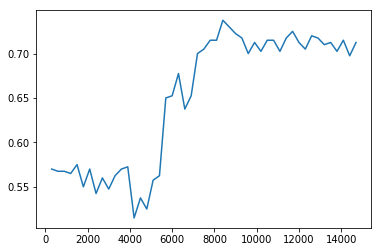

In [71]:
plt.plot(times, accuracies)

ValueError: No axis named  for object type <class 'pandas.core.series.Series'>

In [97]:
10*200

2000